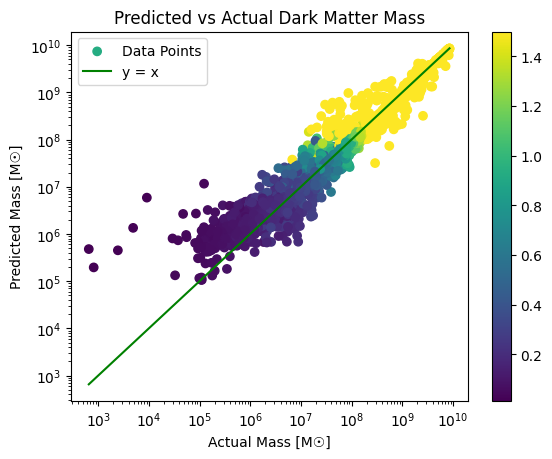

Average Accuracy: 69.903%
Total Stars: 16012
Predicted Stars: 3203


In [2]:
from ml import Model, get_sim_data, get_saved_data

# X, Y = get_sim_data('m10v_res250md', 0, 1)
X, Y = get_saved_data()

model = Model(X, Y)
model.predict()
model.results()